In [1]:
#!virtualenv −p /usr/bin/python3.8 meco2024-radar
#!source meco2024-radar/bin/activate
#!pip install -q -U segmentation-models
#!pip install -q -U gdown
#!pip install -q -U visualkeras
#!pip install -q -U lapixdl

In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from datetime import datetime

import scipy.io
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import os
import keras
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import pickle
import matplotlib.pyplot as plt
import visualkeras
from lapixdl.evaluation.evaluate import evaluate_segmentation
from scipy.linalg import norm
from sklearn.metrics import mean_squared_error
import random
import traceback

from matplotlib.colors import ListedColormap

import segmentation_models as sm
sm.set_framework('tf.keras')
from tqdm.keras import TqdmCallback

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.metrics import MeanIoU

from sklearn.metrics import accuracy_score

Segmentation Models: using `tf.keras` framework.


In [3]:
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent,fast_gradient_method
from cleverhans.tf2.attacks.basic_iterative_method import basic_iterative_method
from cleverhans.tf2.attacks.momentum_iterative_method import momentum_iterative_method

In [4]:
PROJECT_FOLDER = './'

In [5]:
# download dataset
!wget -O converted_dataset.zip https://github.com/ocatak/RadarSpectrumSensing-FL-AML/raw/main/converted_dataset.zip

--2024-05-01 14:41:41--  https://github.com/ocatak/RadarSpectrumSensing-FL-AML/raw/main/converted_dataset.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ocatak/RadarSpectrumSensing-FL-AML/main/converted_dataset.zip [following]
--2024-05-01 14:41:42--  https://raw.githubusercontent.com/ocatak/RadarSpectrumSensing-FL-AML/main/converted_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22101927 (21M) [application/zip]
Saving to: ‘converted_dataset.zip’

converted_dataset.z 100%[===================>]  21,08M  11,6MB/s    in 1,8s    

2024-05-01 14:41:45 (11,6 MB/s) - ‘

In [6]:
def convert_to_int(filename):
    conv_dict = {'Noise':0,'LTE':1,'NR':2, 'Radar': 3}
    f = open(filename,'r')
    f_tmp = open('tmp.txt','w')
    for line in f:
        line_tmp = line
        for key, value in conv_dict.items():
            line_tmp = line_tmp.replace(key,str(value))
        f_tmp.write(line_tmp)
    f_tmp.flush()
    f_tmp.close()
    
    val=pd.read_csv('tmp.txt', sep=',',header=None).values
    return val

In [7]:
dataset_zip_file = 'converted_dataset.zip'
dataset_dir = '.'

print(f'Unzipping dataset file: {dataset_zip_file}')
os.system(f'unzip {dataset_zip_file}')

Unzipping dataset file: converted_dataset.zip
Archive:  converted_dataset.zip


replace data/convertedFolder/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


256

In [8]:
X = []
Y = []
Y_hat = []
LOAD_MODEL = True
TRAIN_MODEL = True

In [9]:
for idx in tqdm(range(1,500)):
    inp = scipy.io.loadmat('data/convertedFolder/rcvdSpectrogram_' + str(idx) + '.mat')['rcvdSpectrogram']
    real = convert_to_int('data/convertedFolder/trueLabels_' + str(idx) + '.csv')
    
    X.append(inp)
    Y.append(real)

  0%|          | 0/499 [00:00<?, ?it/s]

In [10]:
CLASSES = ["Noise", "LTE", "NR", "Radar"]

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1)

x_train = np.array(x_train).astype(float)
x_val = np.array(x_val).astype(float)

y_train = np.array(y_train).astype(float)
y_val = np.array(y_val).astype(float)

# preprocess input
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# Model definition and Data preprocessing

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(input_tensor, num_filters, layer_name=None):
    x = layers.Conv2D(num_filters, 3, padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    if layer_name:
        x = layers.Conv2D(num_filters, 3, padding="same", name=layer_name)(x)
    else:
        x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters, layer_name=None):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.concatenate([x, concat_tensor], axis=-1)
    if layer_name:
        x = conv_block(x, num_filters, layer_name = layer_name)
    else:
        x = conv_block(x, num_filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 32)
    x2, p2 = encoder_block(p1, 64)
    x3, p3 = encoder_block(p2, 128)
    x4, p4 = encoder_block(p3, 256)

    # Bridge
    b = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b, x4, 256)
    d2 = decoder_block(d1, x3, 128)
    d3 = decoder_block(d2, x2, 64)
    d4 = decoder_block(d3, x1, 32, layer_name = "last_conv_layer" )

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation="softmax")(d4)

    model = models.Model(inputs, outputs, name="U-Net")

    return model

In [12]:
# Model summary
input_shape = (256, 256, 3)  # RGB images
num_classes = 4  # Number of classes for segmentation
global_model = build_unet(input_shape, num_classes)

# Compile the model

y_train_onehot = tf.one_hot(y_train.astype(np.int32), depth=num_classes)
y_val_onehot = tf.one_hot(y_val.astype(np.int32), depth=num_classes)

In [13]:
es = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
    min_delta=0.000001, 
    verbose=1
)

mc = ModelCheckpoint(filepath=PROJECT_FOLDER + 'single_model.hdf5', 
                     monitor='val_loss',
                     verbose=1, 
                     save_best_only=True)



In [14]:
def calculate_iou(y_true, y_pred, num_classes):
    """
    Calculate Intersection over Union (IoU) for segmentation tasks.
    """
    iou = MeanIoU(num_classes=num_classes)
    iou.update_state(y_true, y_pred)
    return iou.result().numpy()

def calculate_dice_coefficient(y_true, y_pred):
    """
    Calculate Dice Coefficient for segmentation tasks.
    """
    smooth = 1.
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [15]:
# Initialize global model
NUMBER_OF_EPOCHS = 200

single_model = build_unet(input_shape=(256, 256, 3), num_classes=4)
single_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the combined dataset
single_model.fit(x_train, y_train_onehot, epochs=NUMBER_OF_EPOCHS, verbose=0,validation_split=0.3,
                 callbacks=[TqdmCallback(verbose=1), es,mc])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2024-04-28 16:31:45.906884: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Epoch 1: val_loss improved from inf to 55.08418, saving model to ./single_model.hdf5

Epoch 2: val_loss did not improve from 55.08418

Epoch 3: val_loss did not improve from 55.08418

Epoch 4: val_loss did not improve from 55.08418

Epoch 5: val_loss did not improve from 55.08418

Epoch 6: val_loss did not improve from 55.08418

Epoch 7: val_loss did not improve from 55.08418

Epoch 8: val_loss did not improve from 55.08418

Epoch 9: val_loss did not improve from 55.08418

Epoch 10: val_loss improved from 55.08418 to 15.44035, saving model to ./single_model.hdf5

Epoch 11: val_loss did not improve from 15.44035

Epoch 12: val_loss did not improve from 15.44035

Epoch 13: val_loss did not improve from 15.44035

Epoch 14: val_loss did not improve from 15.44035

Epoch 15: val_loss did not improve from 15.44035

Epoch 16: val_loss did not improve from 15.44035

Epoch 17: val_loss did not improve from 15.44035

Epoch 18: val_loss improved from 15.44035 to 8.32719, saving model to ./single_

In [15]:
single_model = keras.models.load_model(PROJECT_FOLDER + 'single_model.hdf5', compile=True)

## Single model performance results

In [16]:
# Assuming y_val and y_pred are available and properly formatted
num_classes = 4  # Update based on your specific model
metrics_summary = []

for i in range(len(y_val)):
    y_true = y_val[i]
    y_pred = np.argmax(single_model.predict(x_val[i:i+1]), axis=-1)[0]  # Assuming global_model and x_val are defined

    # Calculate metrics
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    precision, recall, f1, _ = precision_recall_fscore_support(y_true.flatten(), y_pred.flatten(), average='macro')
    iou = calculate_iou(y_true, y_pred, num_classes)
    dice = calculate_dice_coefficient(y_true, y_pred)

    metrics_summary.append([accuracy, precision, recall, f1, iou, dice])

# Convert to DataFrame for easy visualization/export
df_metrics = pd.DataFrame(metrics_summary, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU', 'Dice Coefficient'])

# Optionally, save the DataFrame to a CSV file
df_metrics.to_csv('single_model_performance_metrics.csv', index=False)


2024-04-29 10:49:39.302070: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 12ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 13ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 12ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 14ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 13ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 14ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 12ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 14ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 13ms/step


In [17]:
# Calculate mean and standard deviation for each metric
summary_stats = df_metrics.describe().loc[['mean', 'std']]

# For a more compact table, you might only want to show mean and standard deviation
summary_stats = summary_stats.T  # Transpose for easier reading/manuscript formatting
summary_stats.columns = ['Mean', 'Standard Deviation']

# Optionally, format the numbers for presentation
summary_stats = summary_stats.applymap(lambda x: f"{x:.4f}")

print(summary_stats)

                    Mean Standard Deviation
Accuracy          0.9295             0.1039
Precision         0.8415             0.1392
Recall            0.8087             0.1363
F1-Score          0.8108             0.1398
IoU               0.7438             0.1532
Dice Coefficient  1.6308             0.3331


## Perform adversarial attacks to the Radar signals

In [18]:
# Prepare your data (assuming x_val and y_val are prepared)
x_test_adv = x_val[:100]  # Using a smaller subset for demonstration
y_test = y_val[:100]

EXPERIMENT_SIZE = 10

from random import shuffle

# Define attack parameters
attack_functions = [
    ("FGM", fast_gradient_method),
    ("PGD", projected_gradient_descent),
    ("BIM", basic_iterative_method),
    ("MIM", momentum_iterative_method)
]
epsilons = [0.01, 0.1, 0.3, 0.5]
results = []

y_test[y_test == 3] = 0 # All RadarData is noise now.

single_logits_model = tf.keras.Model(single_model.input, single_model.output)

for experiment_no in tqdm(range(EXPERIMENT_SIZE)):
    shuffle(attack_functions)
    for attack_name, attack_function in attack_functions:
        shuffle(epsilons)
        for epsilon in epsilons:
            # Generate adversarial examples
            if attack_name == "FGM":
                x_test_adv = attack_function(single_logits_model, x_test_adv, eps=epsilon,
                                             norm=np.inf, y = y_test.astype(int), targeted=True)
            else:
                x_test_adv = attack_function(single_logits_model, x_test_adv, eps=epsilon, eps_iter=0.01, nb_iter=40,
                                             norm=np.inf, y = y_test.astype(int), targeted=True)

            # Make predictions on adversarial examples
            y_pred_adv = np.argmax(single_model.predict(x_test_adv), axis=-1)

            # Calculate metrics
            accuracy = accuracy_score(y_test.flatten(), y_pred_adv.flatten())
            precision, recall, f1_score, _ = precision_recall_fscore_support(y_test.flatten(), y_pred_adv.flatten(), average='macro')
            iou = calculate_iou(y_test, y_pred_adv, num_classes)
            dice = calculate_dice_coefficient(y_test, y_pred_adv)

            # Append results
            results.append({
                "Attack": attack_name,
                "Epsilon": epsilon,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1_score,
                "IoU": iou,
                "Dice Coefficient": dice
            })
        # print(results)

    # Convert results to a DataFrame for easy visualization/export
    df_results = pd.DataFrame(results)

    # Check if the file exists to decide whether to write the header
    file_exists = os.path.isfile("adversarial_attack_results.csv")

    # Save to CSV
    df_results.to_csv("adversarial_attack_results.csv", mode='a', index=False, header=not file_exists)

  0%|          | 0/10 [00:00<?, ?it/s]

2/2 [==============================] - 1s 274ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 280ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 298ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 314ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 1s 254ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 302ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 307ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 272ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 280ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 302ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 278ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 298ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 297ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 310ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 297ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 281ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 305ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 279ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 274ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 270ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 273ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 291ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 289ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 288ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 296ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 296ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 303ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 277ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 307ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 298ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 289ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 293ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 298ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 312ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 310ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 317ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 257ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 315ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 304ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 302ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 303ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 304ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 291ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 290ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 299ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 299ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 298ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 250ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 303ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 304ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 305ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 302ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 306ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x37f823f90>
    label = <none> 
    device = <AGXG13XDevice: 0x13439ec00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1344f3a00>
        label = <none> 
        device = <AGXG13XDevice: 0x13439ec00>
            name = Apple M1 Pro 
    retainedReferences = 1


2/2 [==============================] - 0s 305ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 304ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 284ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 290ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 293ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 310ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 303ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30d7a3930>
    label = <none> 
    device = <AGXG13XDevice: 0x13439ec00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1344f3a00>
        label = <none> 
        device = <AGXG13XDevice: 0x13439ec00>
            name = Apple M1 Pro 
    retainedReferences = 1


2/2 [==============================] - 0s 302ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 305ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 288ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 287ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 295ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 307ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30d78ced0>
    label = <none> 
    device = <AGXG13XDevice: 0x13439ec00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1344f3a00>
        label = <none> 
        device = <AGXG13XDevice: 0x13439ec00>
            name = Apple M1 Pro 
    retainedReferences = 1


2/2 [==============================] - 0s 303ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 305ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 288ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 329ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 291ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 296ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30d7ecf40>
    label = <none> 
    device = <AGXG13XDevice: 0x13439ec00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1344f3a00>
        label = <none> 
        device = <AGXG13XDevice: 0x13439ec00>
            name = Apple M1 Pro 
    retainedReferences = 1


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x30d7f56c0>
    label = <none> 
    device = <AGXG13XDevice: 0x13439ec00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1344f3a00>
        label = <none> 
        device = <AGXG13XDevice: 0x13439ec00>
            name = Apple M1 Pro 
    retainedReferences = 1


2/2 [==============================] - 0s 290ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 292ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 297ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 304ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 311ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 293ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 280ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 297ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 253ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 294ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 293ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 300ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2/2 [==============================] - 0s 301ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG13XFamilyCommandBuffer: 0x39e180370>
    label = <none> 
    device = <AGXG13XDevice: 0x13439ec00>
        name = Apple M1 Pro 
    commandQueue = <AGXG13XFamilyCommandQueue: 0x1344f3a00>
        label = <none> 
        device = <AGXG13XDevice: 0x13439ec00>
            name = Apple M1 Pro 
    retainedReferences = 1


KeyboardInterrupt: 

In [19]:
# Display the results
print(df_results)

    Attack  Epsilon  Accuracy  Precision    Recall  F1-Score       IoU  \
0      PGD     0.30  0.960681   0.730432  0.717144  0.723654  0.699097   
1      PGD     0.10  0.962603   0.731547  0.720256  0.725814  0.703146   
2      PGD     0.01  0.962752   0.731644  0.720537  0.726006  0.703509   
3      PGD     0.50  0.964549   0.732496  0.723154  0.727770  0.706843   
4      BIM     0.50  0.965262   0.732602  0.723668  0.728083  0.707432   
..     ...      ...       ...        ...       ...       ...       ...   
155    PGD     0.30  0.978274   0.738135  0.731180  0.734620  0.719862   
156    FGM     0.10  0.978105   0.737816  0.731086  0.734415  0.719468   
157    FGM     0.01  0.978141   0.737808  0.731105  0.734420  0.719478   
158    FGM     0.50  0.971754   0.728623  0.727606  0.728103  0.707532   
159    FGM     0.30  0.977625   0.737670  0.730843  0.734225  0.719108   

     Dice Coefficient  
0            1.820912  
1            1.822723  
2            1.822822  
3            1.

# Federated Learning

In [20]:
NUMBER_OF_CLIENTS = 5
NUMBER_OF_EPOCHS = 200
NUM_ROUNDS = 20

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assuming `build_unet` function is your model definition

# Split dataset for 5 clients
def split_data_for_clients(X, Y, num_clients=5):
    client_data = []
    X_split = np.array_split(X, num_clients)
    Y_split = np.array_split(Y, num_clients)
    for i in range(num_clients):
        client_data.append((X_split[i], Y_split[i]))
    return client_data

client_data = split_data_for_clients(np.array(x_train), np.array(y_train), NUMBER_OF_CLIENTS)

# Convert y_train and y_test to one-hot encoding for categorical crossentropy
y_train_onehot = tf.one_hot(y_train.astype(np.int32), depth=4)  # Assuming 4 classes
y_val_onehot = tf.one_hot(y_val.astype(np.int32), depth=4)

epsilons = [0.01, 0.1, 0.3, 0.5]

# Local training function
def train_local_model(client_dataset, global_model):
    model = tf.keras.models.clone_model(global_model)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.set_weights(global_model.get_weights())
    
    X_client, Y_client = client_dataset
    # Select the first 100 inputs for adversarial example generation
    X_client_subset = X_client[:10]
    Y_client_subset = Y_client[:10]
    
    Y_client_onehot = tf.one_hot(Y_client.astype(np.int32), depth=4)  # Assuming 4 classes
    Y_client_subset_onehot = tf.one_hot(Y_client_subset.astype(np.int32), depth=4)
    
    # Y_client_adv = Y_client.copy()
    # Y_client_adv[Y_client_adv == 3] = 0 # All RadarData is noise now.
    
    Y_client_adv = Y_client_subset.copy()
    Y_client_adv[Y_client_adv == 3] = 0  # All RadarData is noise now.
    
    # Generate adversarial examples using multiple attack methods
    logits_model = tf.keras.Model(model.input, model.output)
    
    '''
    epsilon = 0.3  # Perturbation amount
    
    now = datetime.now()
    date_time_str = now.strftime("%Y-%m-%d %H:%M:%S")
    # print(f"{date_time_str} - projected_gradient_descent")
    
    adv_X_client_pgd = projected_gradient_descent(logits_model, X_client_subset, epsilon, 0.01, 40, np.inf,
                                                  y = Y_client_adv.astype(int), targeted=False ) 
    
    now = datetime.now()
    date_time_str = now.strftime("%Y-%m-%d %H:%M:%S")
    # print(f"{date_time_str} - fast_gradient_method")
    
    adv_X_client_fgm = fast_gradient_method(logits_model, X_client_subset, epsilon, np.inf,
                                                  y = Y_client_adv.astype(int), targeted=False)
    
    now = datetime.now()
    date_time_str = now.strftime("%Y-%m-%d %H:%M:%S")
    # print(f"{date_time_str} - basic_iterative_method")
    
    adv_X_client_bim = basic_iterative_method(logits_model, X_client_subset, epsilon, 0.01, 40, np.inf,
                                                  y = Y_client_adv.astype(int), targeted=False)
    
    now = datetime.now()
    date_time_str = now.strftime("%Y-%m-%d %H:%M:%S")
    # print(f"{date_time_str} - momentum_iterative_method")
    
    adv_X_client_mim = momentum_iterative_method(logits_model, X_client_subset, epsilon, 0.01, 40, np.inf,
                                                 decay_factor=1.0,
                                                  y = Y_client_adv.astype(int), targeted=False)
    
    # Combine original and adversarial examples
    combined_X = tf.concat([X_client, adv_X_client_pgd.numpy(),
                            adv_X_client_fgm.numpy(), adv_X_client_bim.numpy(),
                            adv_X_client_mim.numpy()], axis=0)
    # combined_Y = tf.concat([Y_client_onehot]*5, axis=0)  # Replicate labels for adversarial examples
    combined_Y = tf.concat([Y_client_onehot, Y_client_subset_onehot, Y_client_subset_onehot,
                            Y_client_subset_onehot, Y_client_subset_onehot], axis=0)
    '''
    
    # Initialize combined_X with original X_client
    # combined_X = tf.convert_to_tensor(X_client, dtype=tf.float32)
    combined_X = tf.cast(X_client, dtype=tf.float32)
    combined_Y = tf.convert_to_tensor(Y_client_onehot, dtype=tf.float32)
    
    # Generate adversarial examples for each epsilon value and convert them to float32 before concatenation
    for epsilon in epsilons:
        adv_X_client_pgd = tf.cast(projected_gradient_descent(logits_model, X_client_subset, epsilon, 0.01, 40, np.inf,
                                                      y=Y_client_adv.astype(int), targeted=False), dtype=tf.float32)
        adv_X_client_fgm = tf.cast(fast_gradient_method(logits_model, X_client_subset, epsilon, np.inf,
                                                y=Y_client_adv.astype(int), targeted=False), dtype=tf.float32)
        adv_X_client_bim = tf.cast(basic_iterative_method(logits_model, X_client_subset, epsilon, 0.01, 40, np.inf,
                                                  y=Y_client_adv.astype(int), targeted=False), dtype=tf.float32)
        adv_X_client_mim = tf.cast(momentum_iterative_method(logits_model, X_client_subset, epsilon, 0.01, 40, np.inf,
                                                     decay_factor=1.0, y=Y_client_adv.astype(int), targeted=False), dtype=tf.float32)

        # Concatenate adversarial examples generated from each epsilon
        combined_X = tf.concat([combined_X, adv_X_client_pgd, adv_X_client_fgm, adv_X_client_bim, adv_X_client_mim], axis=0)
        combined_Y = tf.concat([combined_Y, Y_client_subset_onehot, Y_client_subset_onehot, Y_client_subset_onehot, Y_client_subset_onehot], axis=0)
        
    es = EarlyStopping( monitor='loss', 
                        patience=15,
                        restore_best_weights=True,
                        min_delta=0.000001, 
                        verbose=1)
    
    # Train the model on the combined dataset
    model.fit(combined_X, combined_Y, epochs=NUMBER_OF_EPOCHS, verbose=0,
              #validation_split=0.3,
              callbacks=[TqdmCallback(verbose=1),es])
    
    return model.get_weights()

# Weight aggregation function
def aggregate_weights(weights_list):
    new_weights = []
    for weights in zip(*weights_list):
        new_weights.append(np.mean(weights, axis=0))
    return new_weights

# Initialize global model
global_model = build_unet(input_shape=(256, 256, 3), num_classes=4)
global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### TMP !!!
# global_model = keras.models.load_model(PROJECT_FOLDER + 'global_model.hdf5', compile=True)

# Federated training loop
for round_num in tqdm(range(NUM_ROUNDS)):
    local_weights = []
    for client_dataset in client_data:
        #print('Client training')
        local_model_weights = train_local_model(client_dataset, global_model)
        local_weights.append(local_model_weights)
    aggregated_weights = aggregate_weights(local_weights)
    global_model.set_weights(aggregated_weights)

    # Optionally evaluate the global model's performance after each round
    # using a validation set or test set
    
    # Evaluate global model on training data
    train_loss, train_accuracy = global_model.evaluate(x_train, y_train_onehot, verbose=0)
    print(f"Training Data - Loss: {train_loss}, Accuracy: {train_accuracy}")
    
    # Evaluate global model on test data
    val_loss, val_accuracy = global_model.evaluate(x_val, y_val_onehot, verbose=0)
    print(f"Validation Data - Loss: {val_loss}, Accuracy: {val_accuracy}")
    
    global_model.save(PROJECT_FOLDER + 'global_model.hdf5')

  0%|          | 0/20 [00:00<?, ?it/s]

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [15]:
global_model = keras.models.load_model(PROJECT_FOLDER + 'global_model.hdf5', compile=True)

2024-05-01 14:41:55.049356: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 402ms/step


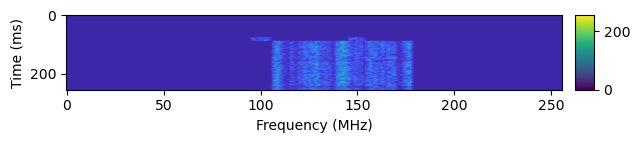

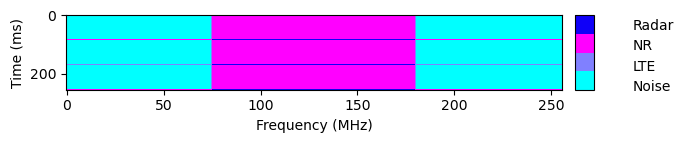

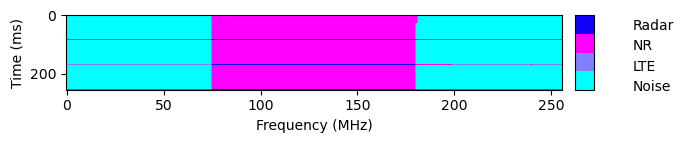

0 masks [00:00, ? masks/s]

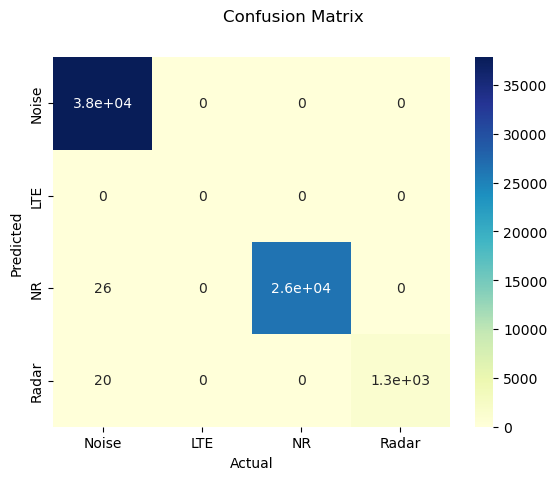

In [16]:
cmp = ListedColormap(['#00FFFF', '#8080FF', '#FF00FF', '#0F00F8'])
for i in range(1):
  input_idx = np.random.randint(low=0,high=x_train.shape[0])

  input_img = x_train[input_idx:input_idx+1]
  real_output = y_train[input_idx:input_idx+1]

  y_pred = global_model.predict(input_img)
  #y_pred_conv = np.round(y_pred*2.0)
  y_pred_conv = np.argmax(y_pred, axis=-1)[0]  # Convert probabilities to class labels

  fig = plt.figure()
  ax = fig.add_subplot(111)
  heatmap = plt.imshow(input_img.reshape((256,256,3)).astype(int))
  plt.ylabel('Time (ms)')
  plt.xlabel('Frequency (MHz)')
  ax.set_aspect(0.15)
  cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
  plt.colorbar(heatmap, cax=cax)
  plt.savefig(PROJECT_FOLDER + 'input_' + str(i) + '.pdf' ,bbox_inches='tight')
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111)
  heatmap = plt.imshow(real_output.reshape((256,256)), cmap=cmp)
  plt.ylabel('Time (ms)')
  plt.xlabel('Frequency (MHz)')
  ax.set_aspect(0.15)
  cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
  cbar = plt.colorbar(heatmap, cax=cax)
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(CLASSES):
      cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
  cbar.ax.get_yaxis().labelpad = 15
  plt.savefig(PROJECT_FOLDER + 'real_' + str(i) + '.pdf' ,bbox_inches='tight')
  plt.show()

  fig = plt.figure()
  ax = fig.add_subplot(111)
  heatmap = plt.imshow(y_pred_conv.reshape((256,256)), cmap=cmp)
  plt.ylabel('Time (ms)')
  plt.xlabel('Frequency (MHz)')
  ax.set_aspect(0.15)
  cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
  cbar = plt.colorbar(heatmap, cax=cax)
  cbar = plt.colorbar(heatmap, cax=cax)
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(CLASSES):
      cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
  cbar.ax.get_yaxis().labelpad = 15
  plt.savefig(PROJECT_FOLDER + 'pred_' + str(i) + '.pdf' ,bbox_inches='tight')
  plt.show()

  eval = evaluate_segmentation(real_output.reshape((256,256)), y_pred_conv.reshape((256,256)), CLASSES)
  fig, axes = eval.show_confusion_matrix()
  fig.savefig(PROJECT_FOLDER + 'cm_' + str(i) + '.pdf' ,bbox_inches='tight')
  plt.show()

## Perform adversarial attack analysis for the global_model

In [17]:
# Assuming y_val and y_pred are available and properly formatted
num_classes = 4  # Update based on your specific model
metrics_summary = []

for i in range(len(y_val)):
    y_true = y_val[i]
    y_pred = np.argmax(global_model.predict(x_val[i:i+1]), axis=-1)[0]  # Assuming global_model and x_val are defined

    # Calculate metrics
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    precision, recall, f1, _ = precision_recall_fscore_support(y_true.flatten(), y_pred.flatten(), average='macro')
    iou = calculate_iou(y_true, y_pred, num_classes)
    dice = calculate_dice_coefficient(y_true, y_pred)

    metrics_summary.append([accuracy, precision, recall, f1, iou, dice])

# Convert to DataFrame for easy visualization/export
df_metrics = pd.DataFrame(metrics_summary, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU', 'Dice Coefficient'])

# Optionally, save the DataFrame to a CSV file
df_metrics.to_csv('global_model_performance_metrics.csv', index=False)

1/1 [==============================] - 0s 12ms/step


/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 13ms/step


In [18]:
# Calculate mean and standard deviation for each metric
summary_stats = df_metrics.describe().loc[['mean', 'std']]

# For a more compact table, you might only want to show mean and standard deviation
summary_stats = summary_stats.T  # Transpose for easier reading/manuscript formatting
summary_stats.columns = ['Mean', 'Standard Deviation']

# Optionally, format the numbers for presentation
summary_stats = summary_stats.applymap(lambda x: f"{x:.4f}")

print(summary_stats)

                    Mean Standard Deviation
Accuracy          0.9821             0.0585
Precision         0.9720             0.0758
Recall            0.9771             0.0847
F1-Score          0.9732             0.0814
IoU               0.9596             0.0946
Dice Coefficient  1.8308             0.2645


In [19]:
x_val.shape[0]

50

## Perform adversarial attacks to the Radar signals on the global model

In [ ]:
EXPERIMENT_SIZE = 30

# Define attack parameters
attack_functions = [
    ("FGM", fast_gradient_method),
    ("PGD", projected_gradient_descent),
    ("BIM", basic_iterative_method),
    ("MIM", momentum_iterative_method)
]
epsilons = [0.01, 0.1, 0.3, 0.5]
results = []

global_logits_model = tf.keras.Model(global_model.input, global_model.output)

for experiment_no in tqdm(range(EXPERIMENT_SIZE)):
    # Prepare your data (assuming x_val and y_val are prepared)
    '''
    x_test_adv = x_val[:100]  # Using a smaller subset for demonstration
    y_test = y_val[:100]
    y_test[y_test == 3] = 0 # All RadarData is noise now.
    '''
    
    # Select a random subset of 100 records from the validation set
    random_indices = np.random.choice(x_train.shape[0], size=50, replace=False)
    # x_test_adv = x_val[random_indices]
    # y_test = y_val[random_indices]
    x_test_adv = x_train[random_indices]
    y_test = y_train[random_indices]
    y_test[y_test == 3] = 0  # All RadarData is noise now.

    for attack_name, attack_function in tqdm(attack_functions):
        for epsilon in epsilons:
            # Generate adversarial examples
            if attack_name == "FGM":
                x_test_adv = attack_function(global_logits_model, x_test_adv, eps=epsilon,
                                             norm=np.inf, y = y_test.astype(int), targeted=True)
            else:
                x_test_adv = attack_function(global_logits_model, x_test_adv, eps=epsilon, eps_iter=0.01, nb_iter=40,
                                             norm=np.inf, y = y_test.astype(int), targeted=True)

            # Make predictions on adversarial examples
            y_pred_adv = np.argmax(global_model.predict(x_test_adv, verbose=False), axis=-1)

            # Calculate metrics
            accuracy = accuracy_score(y_test.flatten(), y_pred_adv.flatten())
            precision, recall, f1_score, _ = precision_recall_fscore_support(y_test.flatten(), y_pred_adv.flatten(), average='macro')
            iou = calculate_iou(y_test, y_pred_adv, num_classes)
            dice = calculate_dice_coefficient(y_test, y_pred_adv)

            # Append results
            results.append({
                "Attack": attack_name,
                "Epsilon": epsilon,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-Score": f1_score,
                "IoU": iou,
                "Dice Coefficient": dice
            })
        # print(results)

    # Convert results to a DataFrame for easy visualization/export
    df_results = pd.DataFrame(results)
    
    # Check if the file exists to decide whether to write the header
    file_exists = os.path.isfile("global_adversarial_attack_results.csv")

    # Save to CSV
    df_results.to_csv("global_adversarial_attack_results.csv", mode='a', index=False, header=not file_exists)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ozgur/miniforge3/lib/python

In [ ]:
# Display the results
print(df_results)

# Analysis
## 1. Feature Visualization

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, class_idx=None):
    # Assume class_idx is the class you're interested in visualizing
    # For segmentation, class_idx can be set to the index of the class of interest
    
    # Create a model that maps the input image to the activations of the last conv layer
    # as well as the output predictions of the model
    grad_model = Model(inputs=[model.inputs], 
                       outputs=[model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            # If class_idx is not specified, use the most confident class
            class_idx = tf.argmax(predictions[0], axis=-1)
        else:
            # Ensure class_idx is a valid tensor for operations below
            class_idx = tf.convert_to_tensor(class_idx, dtype=tf.int64)
        
        # Select the relevant feature map activations for the given class
        relevant_activations = predictions[:, :, :, class_idx]
        tape.watch(conv_outputs)
        grads = tape.gradient(relevant_activations, conv_outputs)

    # Compute the guided gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    #print(conv_outputs)
    #conv_outputs *= pooled_grads[..., np.newaxis]
    
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap#.numpy()

def display_combined(img, prediction, heatmap, alpha=0.4):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Original image
    hm = plt.imshow(img)
    ax.axis('off')
    ax.set_title('Original Image')
    ax.set_aspect(0.15)
    #cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
    #plt.colorbar(heatmap, cax=cax)
    plt.show()
    
    # Prediction
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Original image
    hm = plt.imshow(prediction.reshape((256,256)), cmap=cmp)
    ax.axis('off')
    ax.set_title('Prediction')
    ax.set_aspect(0.15)
    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
    cbar = plt.colorbar(hm, cax=cax)
    cbar.ax.get_yaxis().set_ticks([])
    for j, lab in enumerate(CLASSES):
        cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
    cbar.ax.get_yaxis().labelpad = 15
    plt.show()
    
    
    # Grad-CAM
    heatmap_resized = np.uint8(255 * heatmap)
    heatmap_resized = plt.get_cmap('jet')(heatmap_resized)

    
    #img_superimposed = heatmap_resized[:, :, :3] * alpha*256 + img
    img_superimposed = heatmap_resized[:, :, 1] * alpha*256 + prediction.reshape((256,256))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Original image
    hm = plt.imshow(img_superimposed.astype(int), cmap=cmp)
    ax.axis('off')
    ax.set_title('Grad-CAM')
    ax.set_aspect(0.15)
    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.03,ax.get_position().height])
    cbar = plt.colorbar(hm, cax=cax)
    #cbar.ax.get_yaxis().set_ticks([])
    #for j, lab in enumerate(CLASSES):
    #    cbar.ax.text(3.0, (6.5 * j + 1) / 8.0, lab, ha='left', va='center')
    #cbar.ax.get_yaxis().labelpad = 15
    plt.show()


input_idx = np.random.randint(low=0,high=x_train.shape[0])

img_array = x_train[input_idx:input_idx+1].astype(int)

global_model = build_unet(input_shape=(256, 256, 3), num_classes=4)
global_model.load_weights(PROJECT_FOLDER + 'global_model.hdf5')

# Example usage:
last_conv_layer_name = 'last_conv_layer'
class_idx = 2  # Example class index for which you want to visualize the CAM

heatmap = make_gradcam_heatmap([img_array,], global_model, last_conv_layer_name, class_idx=class_idx)

# Predict and get heatmap
predicted_img = global_model.predict([img_array,])
predicted_img = np.argmax(predicted_img, axis=-1)[0]  # Convert probabilities to class labels

# Assuming you have a function to map your model's prediction to a visual format
# For demonstration, let's assume preds[0] is directly visualizable

# Display combined
display_combined(img_array[0], predicted_img, heatmap, alpha=0.4)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.metrics import MeanIoU



# Assuming y_val and y_pred are available and properly formatted
num_classes = 4  # Update based on your specific model
metrics_summary = []

for i in range(len(y_val)):
    y_true = y_val[i]
    y_pred = np.argmax(global_model.predict(x_val[i:i+1]), axis=-1)[0]  # Assuming global_model and x_val are defined

    # Calculate metrics
    accuracy = accuracy_score(y_true.flatten(), y_pred.flatten())
    precision, recall, f1, _ = precision_recall_fscore_support(y_true.flatten(), y_pred.flatten(), average='macro')
    iou = calculate_iou(y_true, y_pred, num_classes)
    dice = calculate_dice_coefficient(y_true, y_pred)

    metrics_summary.append([accuracy, precision, recall, f1, iou, dice])

# Convert to DataFrame for easy visualization/export
df_metrics = pd.DataFrame(metrics_summary, columns=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'IoU', 'Dice Coefficient'])

# Optionally, save the DataFrame to a CSV file
df_metrics.to_csv('global_model_performance_metrics.csv', index=False)


In [ ]:
# Calculate mean and standard deviation for each metric
summary_stats = df_metrics.describe().loc[['mean', 'std']]

# For a more compact table, you might only want to show mean and standard deviation
summary_stats = summary_stats.T  # Transpose for easier reading/manuscript formatting
summary_stats.columns = ['Mean', 'Standard Deviation']

# Optionally, format the numbers for presentation
summary_stats = summary_stats.applymap(lambda x: f"{x:.4f}")

print(summary_stats)

# To include this in a manuscript, you might convert it to LaTeX or another format
#latex_table = summary_stats.to_latex()

# Printing the LaTeX table string
#print(latex_table)


## Model Decision Explanation